## Source:
adversarial-ml-tutorial.org/




## Diving right in



To start off, let's use the (pre-trained) ResNet50 model within PyTorch to classify this picture of a pig.
!['Show Pig' licensed under CC BY 2.0](pig.jpg)


In [1]:
### PREAMBLE
# Chapter 1 - Introduction to adversarial robustness
# noise.jpg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

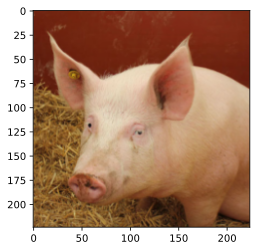

In [2]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

Now let's load the pre-trained ResNet50 model and apply it to the image, after necessary transforms (the weird indexing here is just used to comply with PyTorch standards that all inputs to modules should be of the form `batch_size x num_channels x height x width`).

In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [4]:
# form predictions
pred = model(norm(pig_tensor))

Pred now contains a 1000 dimensional vector containing the class logits for the 1000 imagenet classes (i.e., if you wanted to convert this to a probability vector, you would apply the softmax operator to this vector).  To find the highest likelihood class, we simply take the index of maximum value in this vector, and we can look this up in a list of imagenet classes to find the corresponding label.

In [5]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


### Some introductory notation
Define the model, or hypothesis function, $h_\theta : \mathcal{X} \rightarrow \mathbb{R}^k$ as the mapping from input space (in the above example this would be a three dimensional tensor), to the output space, which is a $k$-dimensional vector, where $k$ is the number of classes being predicted; note that like in our model above, the output corresponds to the logit space, so these are real-valued numbers that can be positive or negative.  

Second, we define a loss function $\ell: \mathbb{R}^k \times \mathbb{Z}_+ \rightarrow \mathbb{R}_+$ , the notation
\begin{equation}
\ell(h_\theta(x), y)
\end{equation}
By far the most common form of loss used in deep learning is the cross entropy loss (also sometimes called the softmax loss), defined as
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y
\end{equation}
where $h_\theta(x)_j$ denotes the $j$th elements of the vector $h_\theta(x)$.

**Aside:** For those who are unfamiliar with the convention above, note that the form of this loss function comes from the typical softmax activation.  Defining the softmax operator $\sigma : \mathbb{R}^k \rightarrow \mathbb{R}^k$ applied to a vector
\begin{equation}
\sigma(z)_i = \frac{exp(z_i)}{\sum_{j=1}^{k}\exp(z_{j})}
\end{equation}
to be a mapping from the class logits returned by $h_\theta$ to a probability distribution.  Then the typical goal of training a network is to maximize the probability of the true class label.  Since probabilities themselves get vanishingly small, it is more common to maximize the _log_ of the probability of the true class label, which is given by
\begin{equation}
\log \sigma(h_\theta(x))_y = \log \left(\frac{exp(h_\theta(x)_y)}{\sum_{j=1}^{k}\exp(h_\theta(x)_{j})} \right) = h_\theta(x)_y - \log \left (\sum_{j=1}^{k}\exp(h_\theta(x)_{j}) \right ).
\end{equation}
Since the convention is that we want to _minimize_ loss (rather than maximizing probability), we use the negation of this quantity as our loss function.  We can evaluate this loss in PyTorch using the following command.

In [6]:
# 341 is the class index corresponding to "hog"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.003882253309711814


A loss of 0.0039 is pretty small: by the conventions above, that would correspond to an $\exp(-0.0039) \approx 0.996$ probability that the classifier believes this to be a pig.

### Creating an adversarial example
So how do we manipulate this image to make the classifier believe it is something else?  To answer this, note that by common approach to training a classifier is to optimize the _parameters_ $\theta$, so as to minimize the average loss over some training set $\{x_i \in \mathcal{X}, y_i \in \mathbb{Z}\}$, $i=1,\ldots,m$, which we write as the optimization problem
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{m} \sum_{i=1}^m \ell(h_\theta(x_i), y_i)
\end{equation}
which we typically solve by (stochastic) gradient descent.  I.e., for some minibatch $\mathcal{B} \subseteq \{1,\ldots,m\}$, we compute the gradient of our loss with respect to the parameters $\theta$, and make a small adjustment to $\theta$ in this negative direction
\begin{equation}
\theta := \theta - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \nabla_\theta \ell(h_\theta(x_i), y_i)
\end{equation}
where $\alpha$ is some step size, and we repeat this process for different minibatches covering the entire training set, until the parameters convergenc.



To construct adversarial example, instead of adjusting the image to minimize the loss, as we did when optimizing over the network parameters, we're going to adjust the image to _maximize_ the loss.  That is, we want to solve the optimization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\hat{x}} \ell(h_\theta(\hat{x}), y)
\end{equation}
We need to ensure that $\hat{x}$ is close to our original input $x$.  By convention, we typically do this by optimizing over the _perturbation_ to $x$, which we will denote $\delta$, and then by optimizing over $\delta$
\begin{equation}
\maximize_{\delta \in \Delta} \ell(h_\theta(x +\delta), y)
\end{equation}

A common perturbation set to use, though by no means the only reasonable choice, is the $\ell_\infty$ ball, defined by the set
\begin{equation}
\Delta = \{\delta : \|\delta\|_\infty \leq \epsilon\}
\end{equation}
where the $\ell_\infty$ norm a vector $z$ is defined as
\begin{equation}
\|z\|_\infty = \max_i |z_i|
\end{equation}
i.e., we allow the perturbation to have magnitude between $[-\epsilon, \epsilon]$ in each of its components (it is a slightly more complex, as we also need to ensure that $x + \delta$ is also bounded between $[0,1]$ so that it is still a valid image).  We'll return later to debeate whether or not is it reasonable to consider the $\ell_\infty$ ball, or norm-balls in general as perturbation sets.  But all we will say for now is that the advantage of the $\ell_\infty$ ball is that for small $\epsilon$ it creates perturbations which add _such_ a small component to each pixel in the image that they are visually indistinguishable from the original image, and thus provide a "necessarily-but-definitely-not-close-to-sufficient" condition for us to consider a classifier robust to perturbations.  And the reality of deep networks is that they can very easily be fooled by manipulations precisely of this type.

Ok, enough discussion.  Let's see what this looks like in practice. 

#### FGSM

In [36]:
import torch.optim as optim
from torch.autograd import Variable
epsilon = 0.1

img_variable = Variable(pig_tensor, requires_grad=True) #convert tensor into a variable
pred = model(norm(img_variable))
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(pred, torch.LongTensor([341]))
loss_cal.backward(retain_graph=True) 

x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
x_adversarial = img_variable.data + epsilon * x_grad          #find adv example using formula shown above
pred_adv = model(norm(x_adversarial))




In [37]:
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())
print("True class probability after adding perturpation:", nn.Softmax(dim=1)(pred_adv)[0,341].item())
label_idx = torch.max(nn.Softmax(dim=1)(pred).data, 1)[1][0].item()   #get an index(class number) of a largest element
print("True label:", label_idx)
label_adv_idx = torch.max(nn.Softmax(dim=1)(pred_adv).data, 1)[1][0].item()   #get an index(class number) of a largest element
print("Adv label:", label_adv_idx)



True class probability: 0.9961252808570862
True class probability after adding perturpation: 0.39992696046829224
True label: 341
Adv label: 341


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


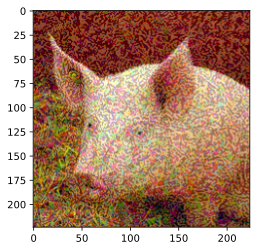

In [31]:
plt.imshow((x_adversarial)[0].detach().numpy().transpose(1,2,0))

#### PGD

In [40]:

epsilon = 2./255

delta = torch.zeros_like(pig_tensor,requires_grad=True)

opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.003882253309711814
5 -0.006934622768312693
10 -0.015810959041118622
15 -0.08060598373413086
20 -12.033530235290527
25 -17.38128089904785
True class probability: 1.5610176262725872e-07


After 30 gradient steps, the ResNet50 thinks that this has less than a $10^{-5}$ chance of being a pig.  (Note: we should also clip $x + \delta$ to be in $[0,1]$, but this already holds for any $\delta$ within the above bound, so we don't need to do it explicitly here).  Instead, it turns out that this classifier is quite sure the image is a wombat, as we can see from the following code, which computes the maximum class and its probability.

In [41]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  wombat
Predicted probability: 0.9999698400497437


So what does this wombat-pig look like?  Extremely similar to our original pig, unfortunately.

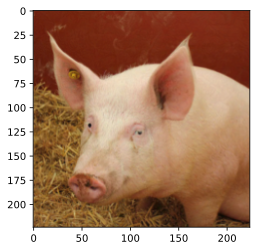

In [42]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Here in fact is the `delta` we added to the image, heavily zoomed in by a factor of 50 because it would be impossible to see otherwise.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


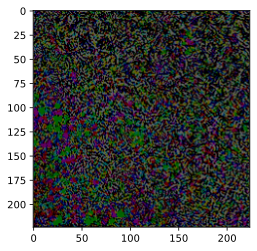

In [48]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

So essentially, by adding a tiny multiple of this random-looking noise, we're able to create an image that looks identical to our original image, yet is classified very incorrectly.  Of course, to do all of this more correctly, we should quantize our noise to the allowable level of the image (i.e., to within steps of 1/255), but technicalities like this are easy to overcome, and we can indeed create valid images which are impossible for the human eye to distinguish between them and our original image, but which the classifier misclassifies.

### Targeted attacks
Ok, you might say.  This is impressive, but a wombat really isn't _that_ different from a pig, so maybe the problem isn't that bad.  But it turns out this same technique can be used to make the image classified as virtually any class we desire.  This is known as a "targeted attack", and the only difference is that instead of trying to just maximize the loss of the correct class, we maximize the loss of the correct class while also minimizing the loss of the target class.  That is, we solve the optimization problem
\begin{equation}
\maximize_{\delta \in \Delta} \left (\ell(h_\theta(x +\delta), y) - \ell(h_\theta(x +\delta), y_{\mathrm{target}}) \right) \equiv \maximize_{\delta \in \Delta} \left(h_\theta(x+\delta)_{y_{\mathrm{target}}} - h_\theta(x+\delta)_{y} ]\right )
\end{equation}
where the expression simplies because the $\log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right )$ terms from each loss cancel, and all that remains is the linear terms.  Here is how this looks.  Note that we tuned the step size a bit to make it work in this case, but we'll shortly consider slightly different scaling methods for projected gradient descent where this isn't needed.

In [43]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([405])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 20.279176712036133
10 -0.22010254859924316
20 -8.64755630493164
30 -19.95289421081543
40 -36.53190994262695
50 -46.38898468017578
60 -51.822540283203125
70 -59.409847259521484
80 -64.04399108886719
90 -72.12857818603516


In [44]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airship
Predicted probability: 1.0


As before, here's our airliner-pig, looking an awful lot like a normal pig (the target class of 404 from the code is indeed an airliner, so our targeted attack is working)

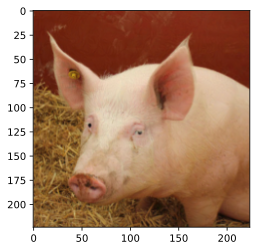

In [45]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

And here is our airliner noise.

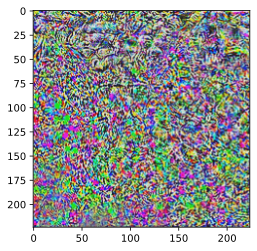

In [52]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

### Adversarial patch

In [141]:
def place_patch(img, patch):
        
        img1 = img.detach().clone()
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img1[:,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
        return img1

In [157]:
patch_size= [50, 50]
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD=[0.229, 0.224, 0.225]
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [158]:
patch = Variable(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
print(patch.shape)

torch.Size([3, 50, 50])


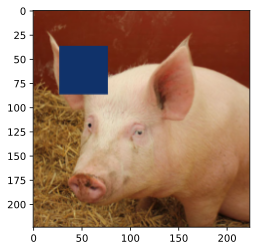

In [159]:
plt.imshow((place_patch(pig_tensor, patch))[0].detach().numpy().transpose(1,2,0))

In [165]:
opt = optim.SGD([patch], lr=1e-1, momentum=0.8)

for t in range(100):
    img = place_patch(pig_tensor, patch)
    pred = model(norm(img))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + nn.CrossEntropyLoss()(pred, torch.LongTensor([404]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

0 7.856968879699707
5 7.974256992340088
10 2.4702954292297363
15 0.7819442749023438
20 -3.399463176727295
25 -3.4699556827545166
30 -3.0453672409057617
35 2.616739273071289
40 -5.333711624145508
45 -0.25481414794921875
50 9.52890396118164
55 7.594870567321777
60 -1.0621967315673828
65 -9.69222640991211
70 7.386675834655762
75 0.14466381072998047
80 -3.7927699089050293
85 -8.459892272949219
90 -6.495577335357666
95 1.2024872303009033
True class probability: 0.0023911716416478157
Predicted class:  soccer_ball
Predicted probability: 0.9764921069145203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


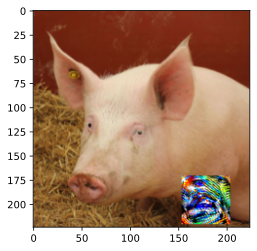

In [166]:
plt.imshow((place_patch(pig_tensor, patch))[0].detach().numpy().transpose(1,2,0))

## Adversarial robustness and training

Let's now consider, a bit more formally, the challenge of attacking deep learning classifiers (here meaning, constructing adversarial examples them the classifier), _and_ the challenge of training or somehow modifying existing classifiers in a manner that makes them more resistant to such attacks.


### Brief review: risk, training, and testing sets
To begin, we can consider more formally the traditional notion of _risk_ as it is used in machine learning.  The risk of a classifier is it's expected loss under the true distribution of samples, i.e.
\begin{equation}
R(h_\theta) = \mathbf{E}_{(x,y)\sim\mathcal{D}}[\ell(h_\theta(x)),y)]
\end{equation}
where $\mathcal{D}$ denotes the true distribution over samples.  In practice, of course, we do not know the underlying distribution of the actual data, so we approximate this quantity by considering a finite set of samples drawn draw i.i.d. from $\mathcal{D}$,
\begin{equation}
D = \{(x_i,y_i) \sim \mathcal{D}\}, i=1,\ldots,m
\end{equation}
and we then consider the empirical risk
\begin{equation}
\hat{R}(h_\theta,D) = \frac{1}{|D|}\sum_{(x,y) \in D} \ell(h_\theta(x)),y).
\end{equation}

As mentioned above, the traditional process of training a machine learning algorithm is that of finding parameters that minimize the empirical risk on some training set denoted $D_{\mathrm{train}}$ (or possibly some regularized version of this objective)
\begin{equation}
\minimize_\theta \hat{R}(h_\theta, D_{\mathrm{train}}).
\end{equation}

Of course, once the parameters $\theta$ have been chosen based upon the training set $D_{\mathrm{train}}$, this data set can no longer give us an unbiased estimated of the risk of the resulting classifier, and so frequently an alterntaive data set $D_{\mathrm{test}}$ (also contains points sampled i.i.d. from the true underlying distribution $\mathcal{D}$), and we use $\hat{R}(h_\theta, D_{\mathrm{test}})$ as a proxy to estimate the true risk $R(h_{\theta})$.


### Adversarial risk
As an alternative to the traditional risk, we can also consider an _adversarial risk_.  This is like the traditional risk, except that instead of suffering the loss on each sample point $\ell(h_\theta(x), y)$, we suffer the _worst case_ loss in some region around the sample point, that is
\begin{equation}
R_{\mathrm{adv}}(h_\theta) = \mathbf{E}_{(x,y)\sim\mathcal{D}}\left[\max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) \right ]
\end{equation}
where for completeness, we explicitly allow that the perturbation region $\Delta(x)$ can depend on the sample point itself; using the examples from the previous sections, this would be necessary in order to ensure that perturbations respected the ultimate image bounds, but it can also potentially encode a great deal of semantic information about what sorts of perturbations would be allowed for each image.

There are also, naturally, the empirical analog of the adversarial risk, which looks exactly like what we considered in the previous sections
\begin{equation}
\hat{R}_{\mathrm{adv}}(h_\theta, D) = \frac{1}{|D|}\sum_{(x,y)\in D} \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) .
\end{equation}
This quantity essentially measures the worst-case empirical loss of the classifier, if we are able to adversarially manipulate every input in the data set within its allowable set $\Delta(x).

Why might we prefer to use the adversarial risk instead of the traditional risk?  If we are truly operating in an adversarial environment, where an adversary is capable of manipulating the input with full knowledge of the classifier, then this would provide a more accurate estimate of the expected performance of a classifier.  This may seem unlikely in practice, but several classification tasks (especially those relating to computer security) such as spam classification, malware detection, network intrusion detection, etc, are genuinely adversarial, where attackers have an direct incentive to fool a classifier.  Or even if we don't expect the evironment to _always_ be adversarial, some applications of machine learning seem to be high-stakes enough that we would like to understand the "worst case" performance of the classifier, even if this is an unlikely event; this sort of logic underlies the interest in adversarial examples in domains like autonomous driving, where for instance there has been work looking at ways that stop signs could be manipulated to intentionally fool a classifier [\cite].



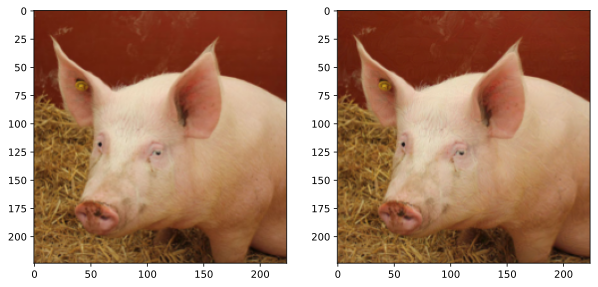

In [168]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

### Training adversarially robust classifiers

With this motivation in mind, let's now consider the task of training a classifier that is robust to adversarial attacks (or equivalently, one that minimizes the empirical adversarial risk).  Analogous to the case of traditional training, this can be written as the optimization problem
\begin{equation}
\minimize_\theta \hat{R}_{\mathrm{adv}}(h_\theta, D_{\mathrm{train}}) 
\equiv \minimize_\theta \frac{1}{|D_{\mathrm{train}}|}\sum_{(x,y)\in D_{\mathrm{train}}} \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) .
\end{equation}
**We will refer to this as the _min-max_ or _robust optimization_ formulation of adversarial learning, and we will return to it many times during the course of this tutorial.**

As with traditional training, the way we would solve this optimization problem in practice is by stochastic gradient descent over $\theta$.  That is, we would repeatedly choose a minibatch $B \subseteq D_{\mathrm{train}}$, and update $\theta$ according to its gradient
\begin{equation}
\theta := \theta - \frac{\alpha}{|B|} \sum_{(x,y)\in B} \nabla_\theta \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y).
\end{equation}
But how do we compute the gradient of the inner term now, given that the inner function itself contains a maximization problem?  The answer is fortunately quite simple in practice, and given by [Danskin's theorem](https://en.wikipedia.org/wiki/Danskin%27s_theorem).  For the purposes of our discussion, it states that the gradient of the inner function involving the maximization term is simply given by the gradient of the function evaluated at this maximum.  In other words, letting $\delta^\star$ denote the optimum of the inner optimization problem
\begin{equation}
\DeclareMathOperator*{\argmax}{argmax}
\delta^\star = \argmax_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y)
\end{equation}
the gradient we require is simply given by 
\begin{equation}
\nabla_\theta \max_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y) = \nabla_\theta \ell(h_\theta(x + \delta^\star)),y)
\end{equation}
(where in the right hand side, we treat $\delta^\star$ just as a fixed quantity, i.e., we don't worry about its dependence on $\theta$).  This may seem to be "obvious", but it is actually quite a subtle point, and it is not trivial to show that this holds (after all the obtained value of $\delta^\star$ depends on $\theta$, so it is not clear why we can treat it as independent of $\theta$ when taking gradient).  We don't prove Danskin's theorem here, and will simply note that this property of course makes our lives much easier.

Given this framework, there is a nice interplay between the challenge of finding an adversarial example, and the process of training a robust classifier.  Specifically, the process of gradient descent on the empircal adversarial risk would look something like the following
  1. For each $x,y \in B$, solve the inner maximization problem (i.e., compute an adversarial example)
  \begin{equation}
  \delta^\star(s) = \argmax_{\delta \in \Delta(x)} \ell(h_\theta(x + \delta)),y)
  \end{equation}
  2. Compute the gradient of the empirical adversarial risk, and update $\theta$
  \begin{equation}
  \theta := \theta - \frac{\alpha}{|B|} \sum_{(x,y)\in B} \nabla_\theta \ell(h_\theta(x + \delta^\star(x))),y).
  \end{equation}

In other words, we iteratively compute adversarial examples, and then update the classifier based not upon the original data points, but upon these adversarial examples.  This procedure has become known as "adversarial training" in the deep learning literature, and (if done properly, more on this shortly) it is one of the most effective empirical methods we have for training adverarially robust models, though a few caveats are worth mentioning.

First, we should note that we are virtually never _actually_ performing gradient descent on the true empirical adversarial risk, precisely because we typically cannot solve the inner maximization problem optimally.  Specifically, the inner maximization, if done via gradient descent like we did above, is a non-convex optimization problem, where we are only able at best to find a local optimum, when using techniques such as gradient descent.  And since Danskin's theorem, for instance, only applies in theory when the inner maximization problem is solved exactly, this would seemingly pose a problem for such approachers.  In practice, however, it typically is the case that if the inner optimization problem is solved "well enough", then the strategy performs well.  It is, though, quite dependent on just how well this inner optimization problem is indeed solved; if only a poor approximate strategy is used to solve the inner maximization problem then there is a good chance that a slightly more exhaustive inner optimization strategy will prove an effective attack.  This is why the best current strategies are ones that explicitly solve this inner optimization problem (even approximately) as well as possible, making it as difficult as possible (thoug not impossible) for a subsequent strategy to simply "out optimize" the trained robustness.

Second, although in theory one can take just the worst-case perturbation as the point at which to compute the gradient, in practice this can cause osscilations of the training process, and it is often better to incorporate multiple perturbations with different random initializations and potentially also a gradient based upon the initial point with no perturbation.

Finally, we should note that some robust training methods (specifically, those based upon uppon bounds on the inner maximization problem), actually do _not_ require iteratively finding an adversarial point and then optimizating; instead, these produce a closed form bound on the inner maximization, that can be solved non-iteratively.  We will discuss such approaches a great deal more in the subsequent sections.

### Final comments

Before moving on, we want to make one additional comment about the value of the robust optimization formulation of adversarial robustness.  It is important to emphasize that **every adversarial attack and defense are a method for approximately solving the inner maximization and/or outer minimization problem respectively**.  Even papers that do not express themselves this way, _are_ attempting to solve these problems (albeit wwith some potential differences, e.g. considering directly a different loss such as the 0/1 loss intead of the cross entropy loss).

In our opinion (and this particular paragraph should very much be interpreted now as the opinion of Zico and Aleksander), one notable challenge with the field is that many papers present an attack or defense in terms of the _method_ it uses, rather than the _problem_ (meaning, optimization problem) it solves.  This is how we get many different names for many different strategies that all consider some minor variant of the above optimization, such as considering different norm bounds in the $\Delta(x)$ term, using different optimization procedures to solve the inner maximization problem, or using seemingly very extravagent techniques to defends against attacks, which often don't seem to clearly relate to the optimization formulation at all.  While it's certainly possible that one such method could prove more effective than the best known strategies we have, the history the more heuristic attack and defense strategies has not been good [\cite].

With all of this in mind, the agenda for the next chapters of this tutorial should hopefully be clear.  In Chapter 2, we will first take a bit of a digression to show how all these issues work in the case of _linear_ models; perhaps not surprisingly, in the linear case, the inner maximization problem we discussed _can_ be solved exactly (or very closely upper bound), and we can make very strong statements about the performance of these models in adversarial settings.  Next, in Chapter 3, we will return to the world of deep networks, and look at the inner maximization problem, focusing on the three general classes of approaches that can be applied: 1) lower bounds (i.e., constructing the adversarial example), 2) exact solutions (via combinatorial optimization), 3) upper bounds (usually with some more-tractable strategy).  In Chapter 4, we then address the problem of training adversarial models, which typically involve either adversarial training using the lower bound, or "certified" robust training involving the upper bounds (adversarial training using the exact combinatorial solutions has not yet been proved feasible).  Finally, Chapter 5 returns to some of the bigger picture questions from this Chapter, and more: here we discuss the value of adversarial robustness beyond the typical "security" justifications; instead, we consider advesarial robustness in the context of regularization, generalization, and the meaningfulness of the learned representations.
